<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex04/patrick_ferreira/ex04_patrick_ferreira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nome: Patrick de Carvalho Tavares Rezende Ferreira

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [2]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [3]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [4]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [5]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [6]:
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

class DataLoader():
    def __init__(self, dataset, batch_size, shuffle):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Esta equacao apenas ARREDONDA a quantidade de mini-batches para CIMA
        # Quando o resultado da divisao nao eh inteiro (sobra resto), significa
        # apenas que o ultimo batch sera menor que os demais
        self.length = len(dataset) // self.batch_size + (len(dataset) % self.batch_size > 0)

        dataset_list = list(dataset)

        if shuffle==True:
            random.shuffle(dataset_list)

        self.x_list, self.y_list = list(zip(*dataset_list))
        self.x_list = torch.cat(self.x_list)
        self.y_list = torch.tensor(self.y_list)

    def __len__(self):
        return self.length

    def __iter__(self):
        self.index = -1
        return self

    def __next__(self):
        self.index += 1
        if self.index < self.length:
            return  self.x_list[self.index * self.batch_size: (self.index + 1) * self.batch_size], \
                    self.y_list[self.index * self.batch_size: (self.index + 1) * self.batch_size]
        else:
            raise StopIteration

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [7]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Modelo

In [8]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

class ModelLinear():
    def __init__(self, in_size, out_size):
        self.weights = torch.zeros((in_size, out_size), requires_grad=True)
        self.bias = torch.zeros((1, out_size), requires_grad=True)

    def forward(self, x):
        return torch.mm(x, self.weights) + self.bias
    
    def __call__(self, x):
        return self.forward(x)

    def parameters(self):
        return self.weights, self.bias

model = ModelLinear(28*28, 10)

## Treinamento

### Inicialização dos parâmetros

In [9]:
n_epochs = 50
lr = 0.1

## Definição da Loss



In [10]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss()

class CrossEntropyLoss():
    def forward(self, y_hat, y):
        exp_x = torch.exp(y_hat)
        sum_x = torch.sum(exp_x, dim=1, keepdim=True)

        y_hat_softmax = torch.log(exp_x / sum_x)

        # Na Cross Entropy, a classe y tem valor 1 para o target e valor 0
        # para todas as outras. Por isso, pegamos apenas o que foi predito pela 
        # rede onde o target vale 1 (que eh o indice guardado em y no MNIST).
        cross_entropy_loss = y_hat_softmax[range(y_hat.shape[0]), y]

        return -torch.mean(cross_entropy_loss)

    def __call__(self, y_hat, y):
        return self.forward(y_hat, y)   

criterion = CrossEntropyLoss()

# Definição do Optimizer

In [11]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)

class SGD():
    def __init__(self, parameters: tuple, learning_rate: float):
        self.parameters = parameters
        self.lr = learning_rate

    def step(self):
        for parameter in self.parameters:
            parameter.data = (parameter.data - self.lr * parameter.grad).detach()

    def zero_grad(self):
        for parameter in self.parameters:
            parameter.grad = torch.zeros(parameter.data.shape)

optimizer = SGD(model.parameters(), lr)

### Laço de treinamento dos parâmetros

In [12]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 1.1979684829711914
Epoch: 1/49 Loss: 0.867622971534729
Epoch: 2/49 Loss: 0.7226786017417908
Epoch: 3/49 Loss: 0.6381281614303589
Epoch: 4/49 Loss: 0.5809750556945801
Epoch: 5/49 Loss: 0.5387411713600159
Epoch: 6/49 Loss: 0.5056463479995728
Epoch: 7/49 Loss: 0.4786270558834076
Epoch: 8/49 Loss: 0.4558936655521393
Epoch: 9/49 Loss: 0.43632185459136963
Epoch: 10/49 Loss: 0.4191650152206421
Epoch: 11/49 Loss: 0.4039044976234436
Epoch: 12/49 Loss: 0.39016804099082947
Epoch: 13/49 Loss: 0.3776799142360687
Epoch: 14/49 Loss: 0.3662314713001251
Epoch: 15/49 Loss: 0.35566139221191406
Epoch: 16/49 Loss: 0.34584280848503113
Epoch: 17/49 Loss: 0.33667415380477905
Epoch: 18/49 Loss: 0.32807353138923645
Epoch: 19/49 Loss: 0.31997358798980713
Epoch: 20/49 Loss: 0.3123182952404022
Epoch: 21/49 Loss: 0.30506113171577454
Epoch: 22/49 Loss: 0.29816243052482605
Epoch: 23/49 Loss: 0.29158854484558105
Epoch: 24/49 Loss: 0.28531038761138916
Epoch: 25/49 Loss: 0.27930301427841187
Epoch: 26/4

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

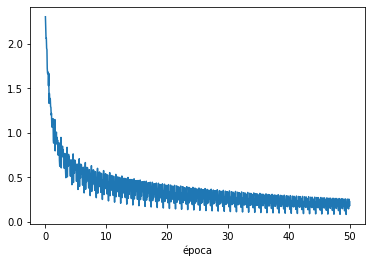

In [13]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

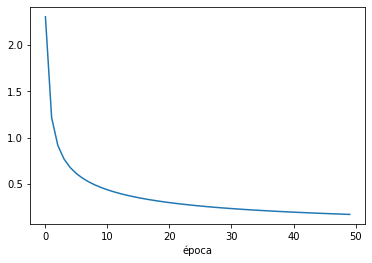

In [14]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [15]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?



Amostra predita corretamente com maior prob:  183
Classe target:  2 . Classe predita:  2


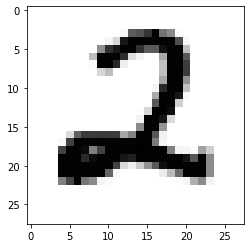



Amostra predita erroneamente com maior prob:  271
Classe target:  3 . Classe predita:  8


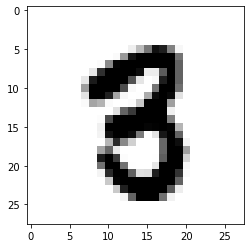



Amostra predita corretamente com menor prob:  532
Classe target:  2 . Classe predita:  2


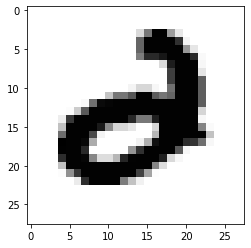



Amostra predita erroneamente com menor prob:  68
Classe target:  5 . Classe predita:  8


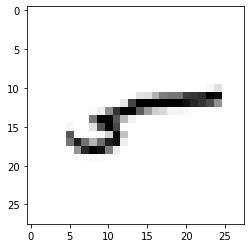

In [16]:
# Escreva o código aqui:

loader_train = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=False) 

x, y = next(iter(loader_train))

x = x.view(x.shape[0], -1)

y_hat = model(x)

exp_x = torch.exp(y_hat)
sum_x = torch.sum(exp_x, dim=1, keepdim=True)

y_hat_softmax = exp_x / sum_x

# Selecionamos os indices que possuiram maior probabilidade na saida da rede (classes que foram preditas)
predict = torch.argmax(y_hat_softmax, axis=1)
# Pegamos os valores de prob preditos para as classes selecionadas na linha acima
predict_prob = torch.max(y_hat_softmax, axis=1)[0]

# Como 0.5 nao eh nem o valor maximo nem minimo de nenhuma das listas de predicoes, 
# escolhi esse valor para preencher as lacunas onde nao houve match na funcao where.
# Isso economiza algumas linhas de codigo
nan_tensor = torch.tensor((0.5,))

verdadeiras = torch.where(predict == y, predict_prob, nan_tensor[0])
falsas = torch.where(predict != y, predict_prob, nan_tensor[0])

def plot_mnist(img):
  plt.imshow(img.reshape(28, 28), cmap='Greys')
  plt.show()

indice = torch.argmax(verdadeiras).item()
print("\n\nAmostra predita corretamente com maior prob: ", indice)
print("Classe target: ", y[indice].detach().numpy(), ". Classe predita: ", predict[indice].detach().numpy())
plot_mnist(x[indice].detach().numpy())

indice = torch.argmax(falsas).item()
print("\n\nAmostra predita erroneamente com maior prob: ", indice)
print("Classe target: ", y[indice].detach().numpy(), ". Classe predita: ", predict[indice].detach().numpy())
plot_mnist(x[indice].detach().numpy())

indice = torch.argmin(verdadeiras).item()
print("\n\nAmostra predita corretamente com menor prob: ", indice)
print("Classe target: ", y[indice].detach().numpy(), ". Classe predita: ", predict[indice].detach().numpy())
plot_mnist(x[indice].detach().numpy())

indice = torch.argmin(falsas).item()
print("\n\nAmostra predita erroneamente com menor prob: ", indice)
print("Classe target: ", y[indice].detach().numpy(), ". Classe predita: ", predict[indice].detach().numpy())
plot_mnist(x[indice].detach().numpy())

## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.
